# Testing PA tagged rel04
This notebook is meant to be a demo for creating a rel04 pitch angle tagged product

Features
1. Splitting up counts within the field of view by the response function (DONE)
1. Compute PA for all the points in the split
1. Pixel corrections based on PA distribution matching between pixels
1. energy channel interpolation


## Splitting up counts within the field of view by the response function (DONE)


In [1]:
import ctypes
import ctypes.util
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp

%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
sc_uvw_rot = np.matrix([[ 0.81915204, -0.57357644,  0.        ],
                            [ 0.57357644,  0.81915204,  0.        ],
                            [-0.        ,  0.        ,  1.        ]])

In [3]:
np.asarray((np.array([0,0,1])*sc_uvw_rot))[0]

array([ 0.,  0.,  1.])

In [4]:
    # 80 degree rotation around z
    hope3_rot = np.matrix([[ 0.98480775,  0.17364818,  0.        ],
                           [-0.17364818,  0.98480775,  0.        ],
                           [ 0.        ,  0.        ,  1.        ]]).transpose()

In [5]:
print(np.rad2deg(np.arccos(hope3_rot[1,1])))
print(np.rad2deg(np.arcsin(hope3_rot[0,0])))


10.0000009939
79.9999990061


In [6]:
np.cos(np.deg2rad(80)), np.sin(np.deg2rad(80))

(0.17364817766693041, 0.98480775301220802)

In [7]:
deg_polar_1 = np.matrix([[ np.cos(np.deg2rad(1)),  np.sin(np.deg2rad(1)),  0.        ],
                           [-np.sin(np.deg2rad(1)),  np.cos(np.deg2rad(1)),  0.        ],
                           [ 0.        ,  0.        ,  1.        ]]).transpose()

In [8]:
newrot = hope3_rot * deg_polar_1
print(newrot)

[[ 0.98162718 -0.190809    0.        ]
 [ 0.190809    0.98162718  0.        ]
 [ 0.          0.          1.        ]]


In [9]:
print(np.rad2deg(np.arccos(newrot[1,1])))
print(np.rad2deg(np.arcsin(newrot[0,0])))

11.0000009166
78.9999990834


In [10]:
np.cos(np.deg2rad(79)), np.sin(np.deg2rad(79))

(0.19080899537654492, 0.98162718344766398)

In [11]:
np.sqrt(3)*np.sqrt(2), np.sqrt(3*2)

(2.4494897427831783, 2.4494897427831779)

## Compute PA for all the points in the split


In [12]:
# from make_HOPE_PA_tags_rel04 import EventTimer, smart_tt2000_to_epoch, makeFullTimes_Ele, makeFullTimes_Ion
# from make_HOPE_PA_tags_rel04 import interpolateB, extract_date_string, L1arg, Barg


# from make_HOPE_PA_tags_rel04 import split_fov

import make_HOPE_PA_tags_rel04 as rel04

In [13]:
args = ['~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf', 
        '~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf',
        'rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf']
outfile = args[-1]
date_string = rel04.extract_date_string(outfile)
L1infile, sc1 = rel04.L1arg(args[:-1])
Binfile, scB = rel04.Barg(args[:-1], date_string)
assert (np.asarray([sc1, scB]) == sc1).all()

libname = os.path.join('/Users/blarsen/git/hope/pitch_angle', 'lib_hope_angles_' + os.environ['HWSWID']) + '.so'
lib = ctypes.CDLL(os.path.abspath(libname))

print(L1infile, Binfile, outfile, libname)
for f in (L1infile, Binfile, outfile, libname):
    print(os.path.isfile(os.path.expanduser(f)))
    
if os.path.isfile(outfile):
    os.remove(outfile)

~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf ~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf /Users/blarsen/git/hope/pitch_angle/lib_hope_angles_OSX.so
True
True
False
True


1. Read in all the infiles
1. Compute the time of each measurement 
1. Interpolate the magnetometer to each of of the measurement times

In [14]:
Time1 = time.time()
# Open the CDF files
L1cdf = pycdf.CDF(L1infile)
Bcdf = pycdf.CDF(Binfile)
Time1 = rel04.EventTimer('CDFs open', Time1)  # time

TaggedData = dm.SpaceData()
rel04.makeFullTimes_Ele(L1cdf, TaggedData)
Time1 = rel04.EventTimer('Full times computed electrons', Time1)  # time
rel04.makeFullTimes_Ion(L1cdf, TaggedData)
Time1 = rel04.EventTimer('Full times computed ions', Time1)  # time

magInterp_Ele, magInterp_Ion = rel04.interpolateB(TaggedData, Bcdf, lib)
Time1 = rel04.EventTimer('Magnetometer interpolated', Time1)  # time



0.64 CDFs open
0.59 Full times computed electrons
0.74 Full times computed ions
1.56 Magnetometer read from disk
0.65 Measurement fractions computed
1.04 Slerp finished
0.44 Measurement fractions computed
0.70 Slerp finished
4.42 Magnetometer interpolated


TaggedData
+
|____Epoch_Ele (spacepy.datamodel.dmarray (4143,))
|____Epoch_Ele_FRAME_subtime (numpy.ndarray (16, 72))
|____Epoch_Ion (spacepy.datamodel.dmarray (3469,))
|____Epoch_Ion_FRAME_subtime (numpy.ndarray (16, 72))
|____Full_times_Ele (numpy.ndarray (4143, 16, 72))
|____Full_times_Ion (numpy.ndarray (3469, 16, 72))


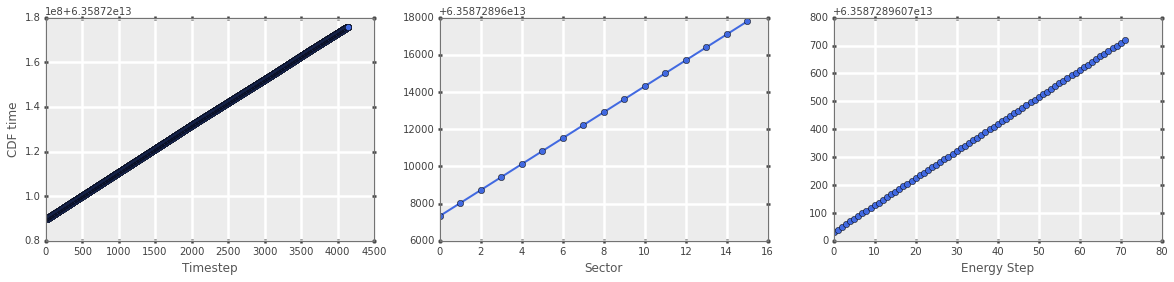

In [15]:
print('TaggedData')
TaggedData.tree(verbose=True)
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(131)
ax.plot(TaggedData['Full_times_Ele'][:,0,0], '-o', lw=2)
plt.xlabel('Timestep')
plt.ylabel('CDF time')

ax = fig.add_subplot(132)
ax.plot(TaggedData['Full_times_Ele'][0,:,0], '-o', lw=2)
plt.xlabel('Sector')

ax = fig.add_subplot(133)
ax.plot(TaggedData['Full_times_Ele'][0,0,:], '-o', lw=2)
plt.xlabel('Energy Step')


In [16]:
hope1_rot = np.matrix([[0.30432233, 0.17364818, 0.93660783],
                       [-0.05366024, 0.98480775, -0.16514923],
                       [-0.95105652, 0., 0.30901699]]).transpose()
hope2_rot = np.matrix([[0.79672621, 0.17364818, 0.57885547],
                       [-0.14048433, 0.98480775, -0.10206784],
                       [-0.58778525, 0., 0.80901699]]).transpose()
# 80 degree rotation around z
hope3_rot = np.matrix([[0.98480775, 0.17364818, 0.],
                       [-0.17364818, 0.98480775, 0.],
                       [0., 0., 1.]]).transpose()
hope4_rot = np.matrix([[0.79672621, 0.17364818, -0.57885547],
                       [-0.14048433, 0.98480775, 0.10206784],
                       [0.58778525, 0., 0.80901699]]).transpose()
hope5_rot = np.matrix([[0.30432233, 0.17364818, -0.93660783],
                       [-0.05366024, 0.98480775, 0.16514923],
                       [0.95105652, 0., 0.30901699]]).transpose()

rots = (hope1_rot, hope2_rot, hope3_rot, hope4_rot, hope5_rot)

# spin axis is omega
# compute omega in uvw
sc_uvw_rot = np.matrix([[0.81915204, -0.57357644, 0.],
                        [0.57357644, 0.81915204, 0.],
                        [-0., 0., 1.]])
# omega is along Z in xyz and uvw!!  But leave this in for tuning
omega_uvw = np.asarray((np.array([0, 0, 1]) * sc_uvw_rot))[0]

In [17]:
# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {

lib.computePAarb.argtypes = (np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=2, shape=(3,3), flags='C'),  # rot
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, shape=(3,), flags='C'),  # magInterp
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=2, flags='C'),  # offset
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, flags='C'),  # PA
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, flags='C'),  # PHI
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, shape=(3,), flags='C'),  # omega
                             ctypes.c_long,   # n_values
                            )
lib.computePAarb.restype = ctypes.c_long # number of calculations

In [18]:

# PA[][N_PIXELS][N_SECTORS][N_ENERGIES],
N_TIMES = L1cdf['Elc_Cntr_e'].shape[0]
N_PIXELS = 5
N_SECTORS = 16
N_ENERGIES = 72




Choose 1 time, 1 pixel, 1 sector, 1 energy and split up coutns and do PA,PHA calculation

(110, 3)
-8.0 6.0
magInterp_in (3,)
offset_in (110, 2)
PA (110,) PHI (110,)
omega_uvw_in (3,)


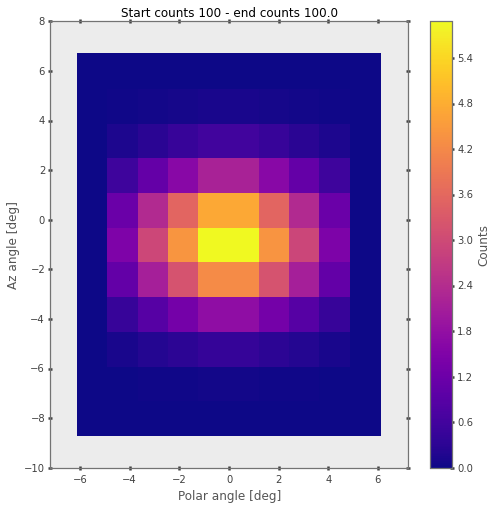

In [19]:
t_ind = 100 # make sure not a BS mode for testing
pixel = 3
sector = 1
energy = 32

n_polar=10
n_azi=11

# def split_fov(counts, pixel, sc, n_polar=10, n_azi=11, plot=False):

fov_split = rel04.split_fov(100, pixel, 'a', plot=True,  n_polar=n_polar, n_azi=n_azi)

print(fov_split.shape)
print(fov_split.min(), fov_split.max())



rot_in = np.require(rots[pixel-1],
                   dtype=ctypes.c_double,
                    requirements='C')


magInterp_in = np.require(magInterp_Ele[t_ind, sector, energy], dtype=ctypes.c_double, requirements='C')
print('magInterp_in', magInterp_in.shape)

offset_in = np.require(fov_split[:, 0:2], dtype=ctypes.c_double, requirements='C')
print('offset_in', offset_in.shape)

PA = np.empty(np.product((n_polar, n_azi)), dtype=ctypes.c_double, order='C')
PA[...] = -999
PHI = np.empty(np.product((n_polar, n_azi)), dtype=ctypes.c_double, order='C')
PHI[...] = -999

print('PA', PA.shape, 'PHI', PHI.shape)

omega_uvw_in = np.require(omega_uvw, dtype=ctypes.c_double, requirements='C')

print('omega_uvw_in', omega_uvw_in.shape)


    
# rotnp = np.require(np.dstack([np.asarray(rots[pixel]).T] * np.product(shape)).T,
#                    dtype=ctypes.c_double,
#                    requirements='C')

# mag_tmp = np.require(magInterp_Ele[:, sector, energy].reshape(-1, 3),
#                      dtype=ctypes.c_double,
#                      requirements='C')


110 110


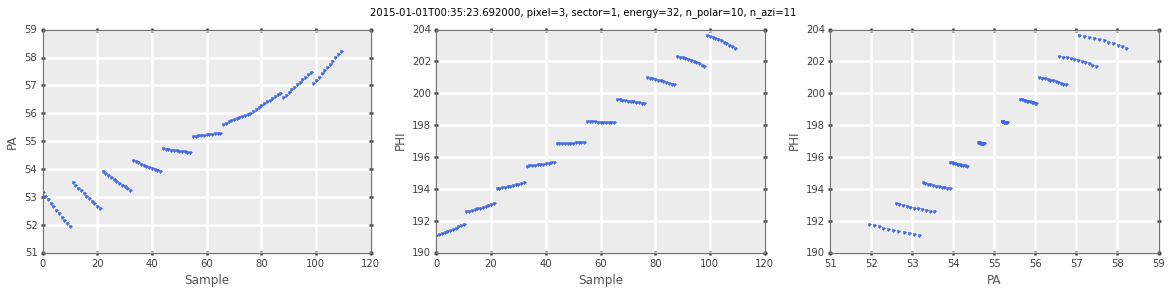

In [20]:
# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA))
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                    n_polar, n_azi))





<class 'numpy.ndarray'> <class 'numpy.ndarray'>


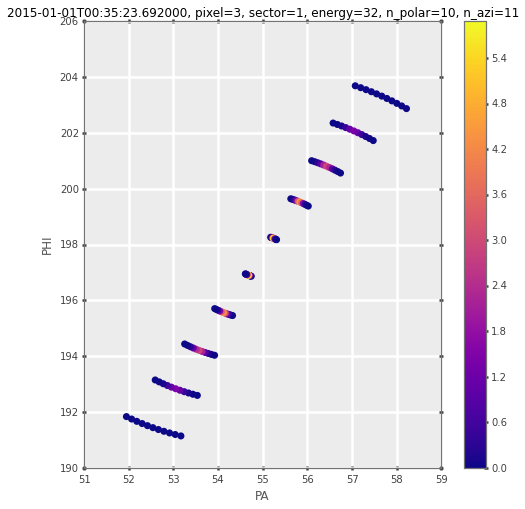

In [21]:
# plot the counts as the color of each point

plt.figure(figsize=(8,8))
print(type(PA), type(PHI))



plt.scatter(PA, PHI, c=fov_split[:,2], s=50)
plt.xlabel('PA')
plt.ylabel('PHI')
plt.title('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                    n_polar, n_azi))
plt.colorbar()

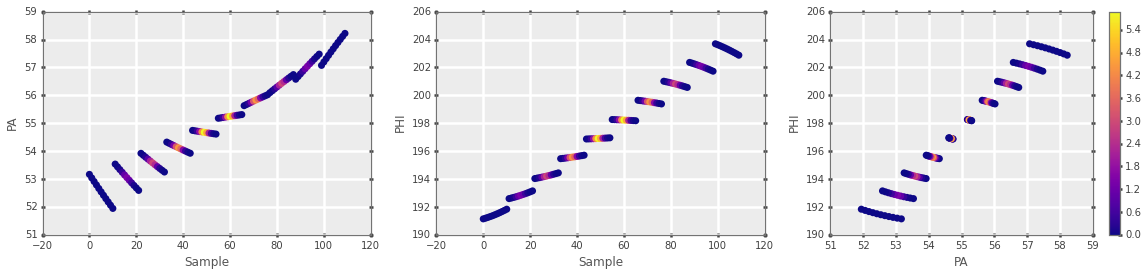

In [22]:

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=fov_split[:,2], s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)